# Model 2: Machine learning algorithm

In [69]:
# import libraries: standard env, +pysal, + jupyter, + matplotlib
#### import libraries ####
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
os.getcwd()

start = timeit.default_timer()

## 1. Read Data

In [70]:
# Read FS data
FS = pd.read_csv('Data/FS_data.csv')


In [71]:
# **Combine processed FS shapefile w/ sars data**

## 2. Model Preprocessing

In [72]:
# Drop unnecessary columns (i.e. space/time no longer need because lags are accounted for)
admin_code = FS['admin_code']
data = FS.drop(['country', 'admin_code', 'admin_name', 'year_month', 'year', 'month', 'geometry'], axis=1)

**Addressing missing values**

 - If 25% of a columns data is NA, that column is removed
 - For all other missing values, the column mean is used - BUT need a better option!

In [73]:
# Establish how much data is missing
print(data.isnull().sum().sort_values(ascending=False).head())

# Find the columns with large amounts of na values
variables_na = []
for i in data:
    if data[i].isnull().sum() > 554:
        str(i)
        variables_na.append(i)
data = data.drop(columns=variables_na) #delete those

timelag2     540
timelag1     270
fews_ipc       0
ndvi_mean      0
rain_mean      0
dtype: int64


In [74]:
# Impute the missing values using SimpleImputer in sklearn.impute
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(data)

data = pd.DataFrame(data=imp.transform(data), columns=data.columns)

# Check if there is still missing data
data.isnull().sum().sort_values(ascending=False).head()

fews_ipc       0
ndvi_mean      0
rain_mean      0
et_mean        0
acled_count    0
dtype: int64

**Normalize the data set**
- Scales each column to values between 0-1 to be better interpreted by the models
- CHECK: how normalisation impacts model accuracy

In [75]:
fews_ipc = data['fews_ipc']
data = data.drop(['fews_ipc'], axis=1)
scaler = MinMaxScaler()
data = gpd.GeoDataFrame(scaler.fit_transform(data), columns=data.columns, index=FS.index)
data.head()
data.describe()
data['class'] = fews_ipc

**Add Binary Classification**
- Using column quartiles as a suitable threshold base
- CHECK: how classification complexity impacts models
- NOTE: Using +3 classes would be more informative in our model explorations

In [76]:
# Binary classification based on quartiles
data['class'] = [0 if x == 1 else 1 for x in data['class']]
data['class'] = data['class'].astype(float) # Reformat column


## Random Forest Classification

In [77]:
# Load functions

# For plotting confusion matrix
def plot_confusion_matrix(train_pred, train, dom):
    classes = {'Food Security': 0, 'Food Insecurity': 1}
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.title(f'{dom} Confusion matrix')
    plt.tight_layout()
    plt.figure(figsize=(1, 2), dpi=80)
    plt.show()


In [78]:
#### RANDOM FOREST CLASSIFICATION ####

# A. SPLIT TRAIN/TEST SETS
# Random 70% split in train and test sets (time series is accounted for by lags)
# split data into x & y
y = data['class']
x = data.drop(columns=['class'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [79]:
# B. OPTIMISE MODEL HYPERPARAMETERS
# Hyperparameter grid search (112)
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [80]:
# CREATE RANDOM GRID SEARCH
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10] # seq(1, 14, by = 1),
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid


{'n_estimators': [200, 400, 600, 800, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [81]:
# start = timeit.default_timer()
#
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation,
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(x_train,y_train)
#
# stop = timeit.default_timer()
# print('Time: ', stop - start)

In [82]:
# rf_random.best_params_

# optimal = {'n_estimators': 600,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 70,
#  'bootstrap': False}

In [83]:
# Evalaute Random grid search
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(x_train,y_train)
# base_accuracy = evaluate(base_model, x_train,y_train)
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, x_train,y_train)
# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# Random grid search narrows down range but we can do better

In [84]:
# from sklearn.model_selection import GridSearchCV
#
# # Create the parameter grid based on the results of random search
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [50, 60, 70, 80, 90],
#     'max_features': [2, 3],
#     'min_samples_leaf': [1],
#     'min_samples_split': [2],
#     'n_estimators': [400, 500, 600, 700, 800]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(x_train,y_train)
#
# grid_search.best_params_

In [85]:
# optimal
# {'bootstrap': False,
#  'max_depth': 90,
#  'max_features': 2,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 600}

In [86]:
# C. RESULTS
# Fit optimised model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)

RandomForestClassifier()

Ensemble Train Model Accuracy(in %): 100.0
Ensemble Test Model Accuracy(in %): 97.09876543209876


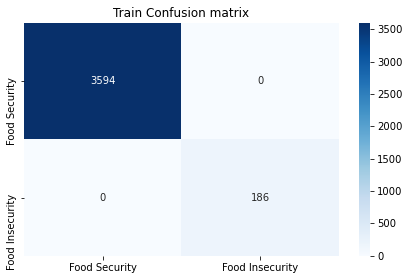

<Figure size 80x160 with 0 Axes>

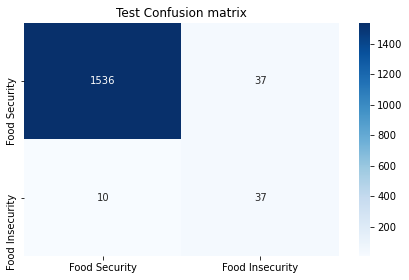

<Figure size 80x160 with 0 Axes>

In [87]:
# Evaluate model
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print(f'Ensemble Train Model Accuracy(in %): {metrics.accuracy_score(y_train_pred,y_train)*100}')
print(f'Ensemble Test Model Accuracy(in %): {metrics.accuracy_score(y_test_pred,y_test)*100}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

ndvi_mean = 0.1520361537545595
rain_mean = 0.1461209847940905
et_mean = 0.11170127011991456
acled_count = 0.015909423775845873
acled_fatalities = 0.011278788752136707
p_staple_food = 0.15106810884425884
area = 0.03638725890398863
cropland_pct = 0.08076559110123545
pop = 0.12913796468302405
ruggedness_mean = 0.05344216765671112
pasture_pct = 0.05599524970195145
spacelag = 0.006947239756685836
timelag1 = 0.012220795648411482
timelag2 = 0.036989002507185835


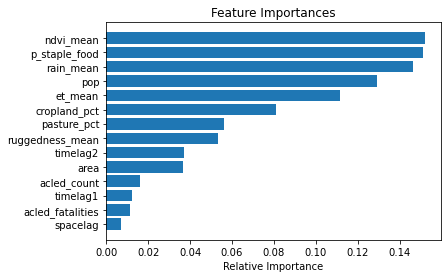

In [93]:
# Evaluate Variable importance

for name, importance in zip(x_test.columns, clf.feature_importances_):
    print(name, "=", importance)

features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center') # color
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [89]:
# Make individual prediction


stop = timeit.default_timer()
print('Running Time: ', stop - start, 'seconds')

Time:  2.4385471000000507
